In [1]:
import torch
import pandas as pd
from matplotlib import pyplot as plt
from basis import *
import nf_class

device = torch.device('cpu')

In [2]:
expo_scale = 1
shape,scale=10/4,1

In [6]:
x = torch.tensor(pd.read_csv('datasets/E_{}_G_{}_{}.csv'.format(expo_scale,shape,scale),header=None).to_numpy()[:10000].reshape(-1))
bins = torch.linspace(x.min(),x.max(),51).numpy()
xb = torch.linspace(1e-3,(x.max().item()),10000)
p_gt = torch.exp(logprob_gamma(xb,torch.tensor(shape),torch.tensor(scale)))


In [7]:
def Bayes_fig(ax,N):
    filename = 'models/Prod_Bayes_N_{}_E_{}_G_{}_{}.csv'.format(N,expo_scale,shape,scale)
    sps,scs,lps =  torch.tensor(pd.read_csv(filename).to_numpy()[:,1:].T)

    i = torch.argmax(lps)
    p_map = torch.exp(logprob_gamma(xb,sps[i],scs[i]))


    logp = torch.logsumexp(torch.vstack([logprob_gamma(xb,sp,sc) for (sp,sc) in zip(sps,scs)]),axis=0)-torch.log(torch.tensor(len(lps))).to(device)
    p = torch.exp(logp)
    
    ax.plot(xb.cpu(),p_gt.cpu(),label='Ground Truth ', lw = 2.0,color='k')
    ax.plot(xb.cpu(),p_map.cpu(),label='MAP'.format(KL(p_gt,p_map,xb)))
    ax.plot(xb.cpu(),p.cpu(),label='Reconstruction'.format(KL(p_gt,p,xb)))
    ax.legend()



def Mixture_fig(ax,N,Ncomp=20,burn=5000):

    logprob_mixgaussian = lambda x,mus,sigs,rhos:torch.logsumexp(logprob_gaussian(x,mus.reshape(-1,1),sigs.reshape(-1,1))+torch.log(rhos.reshape(-1,1)),axis=0)
    logprob_mixlognormal = lambda x,mus,sigs,rhos: logprob_mixgaussian(torch.log(x),mus,sigs,rhos)-torch.log(x)

    filename = 'models/Prod_NPBayes_N_{}_E_{}_G_{}_{}.csv'.format(N,expo_scale,shape,scale)
    g = pd.read_csv(filename).to_numpy()[:,1:]
    thetas,lps = torch.tensor(g[burn:,:-1]),torch.tensor(g[burn:,-1])

    i = torch.argmax(lps)
    
    th_map = thetas[i]
    p_map = torch.exp(logprob_mixlognormal(xb,th_map[:Ncomp],th_map[Ncomp:2*Ncomp],th_map[2*Ncomp:]))

    logp = torch.logsumexp(torch.vstack([logprob_mixlognormal(xb,th[:Ncomp],th[Ncomp:2*Ncomp],th[2*Ncomp:]) for th in thetas]),axis=0)-torch.log(torch.tensor(len(lps))).to(device)
    p = torch.exp(logp)
    
    ax.plot(xb.cpu(),p_gt.cpu(),label='Ground Truth ', lw = 2.0,color='k')
    ax.plot(xb.cpu(),p_map.cpu(),label='MAP')
    ax.plot(xb.cpu(),p.cpu(),label='Reconstruction')
    ax.legend()


def NF_fig(ax,N):
    model = nf_class.ProdDeconvolver(x,torch.distributions.Exponential(1))
    model.load_state_dict(torch.load( 'models/Prod_nf_N_{}_E_{}_G_{}_{}'.format(N,expo_scale,shape,scale)+'datapoints_{}.pt'.format(N)))
 
    p_nf = model.get_pdf(xb)[1]
    ax.plot(xb.cpu(),p_gt.cpu(),label='Ground Truth ', lw = 2.0,color='k')
    ax.plot(xb.cpu(),p_nf.cpu(),label='NF',color='r')
    ax.legend()


/home/pessoa/Codes/Zeta/nf_class.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mu = torch.tensor(mu).to(device)
/home/pessoa/Codes/Zeta/nf_class.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sig = torch.tensor(sig).to(device)
/home/pessoa/Codes/Zeta/nf_class.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mu = torch.tensor(mu).to(device)
/home/pessoa/Codes/Zeta/nf_class.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detac

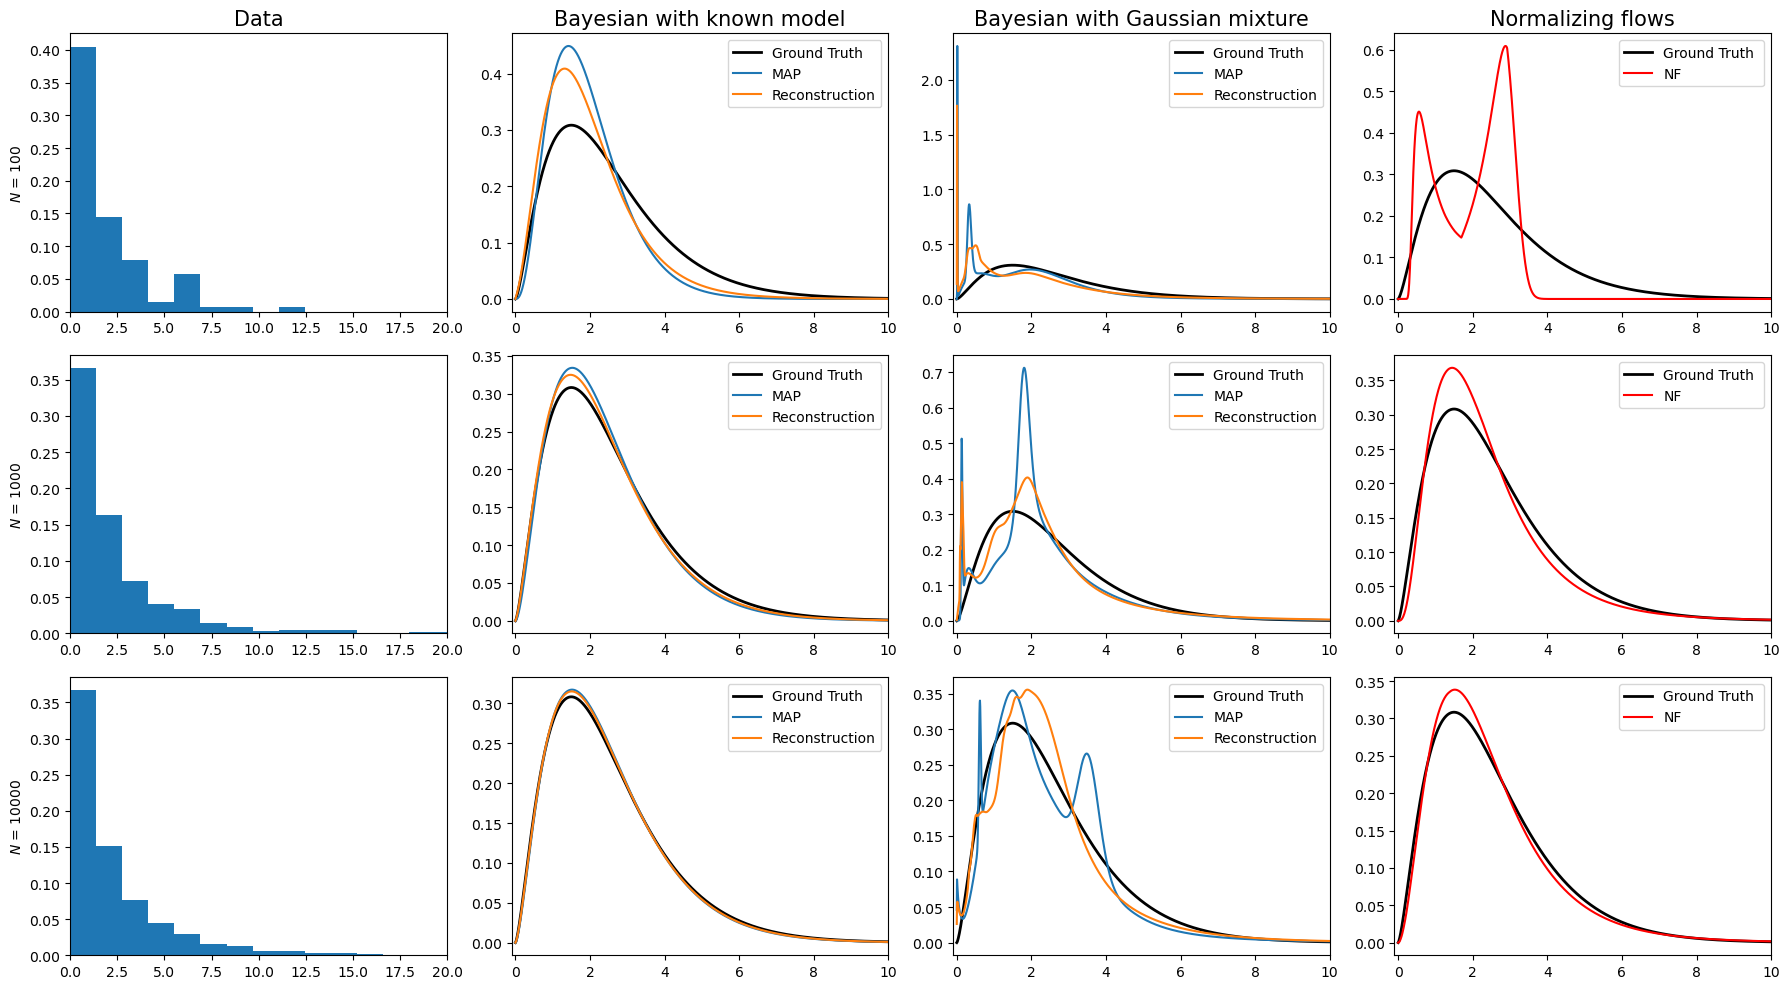

In [9]:
fig,axs = plt.subplots(3,4,figsize=(18,10))
for (ax,N) in zip(axs,(100,1000,10000)):
    ax[0].hist(x[:N],density=True,bins=bins)
    ax[0].set_xlim(0,20)
    Bayes_fig(ax[1],N)
    ax[1].set_xlim(-.1,10)
    Mixture_fig(ax[2],N)
    ax[2].set_xlim(-.1,10)
    NF_fig(ax[3],N)
    ax[3].set_xlim(-.1,10)

    ax[0].set_ylabel(r'$N$ = {}'.format(N))

[ax.set_title(tit,fontsize=15) for (tit,ax) in zip(('Data', 'Bayesian with known model', 'Bayesian with Gaussian mixture', 'Normalizing flows'), axs[0])]
plt.tight_layout()
plt.savefig('graphs/fig3.png',dpi=500)